In [1]:
# a notebook to check batch surface reactor in 2.6 vs. 3.1.0

In [2]:
import cantera as ct
import numpy as np
import scipy.signal
import os

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(ct.__version__)

3.1.0


In [4]:
# Pt111
# mech_yaml = '/home/moon/uncertainty_estimator/nam29_presentation/cpox_Pt/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated.yaml'

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

# gas, _ = ct.import_phases(mech_yaml, ["gas", "surface1"])
# surf = ct.Interface(mech_yaml, 'surface1')  # new way

# surf = ct.Interface(mech_yaml,'surface1')
# gas = surf.adjacent['gas']

print(f'This mechanism contains {gas.n_species} gas species and {surf.n_species} surface species')
print(f'This mechanism contains {gas.n_reactions} gas reactions and {surf.n_reactions} surface reactions')

This mechanism contains 24 gas species and 21 surface species
This mechanism contains 62 gas reactions and 145 surface reactions


In [5]:
def get_i_thing(ref_composition, phase):
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False
    return -1

In [29]:
# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_C2H4 = get_i_thing({'C': 2.0, 'H': 4.0}, gas)
i_x = get_i_thing({'X': 1.0}, surf)
i_OX = get_i_thing({'X': 1.0, 'O': 1.0}, surf)
i_HX = get_i_thing({'X': 1.0, 'H': 1.0}, surf)
i_CH3X = get_i_thing({'X': 1.0, 'H': 3.0, 'C': 1.0}, surf)

In [7]:
# Make the colors consistent between all mechanism
np.random.seed(400)
color_dict = {
    "{'X': 1.0}": '#1f77b4',
    "{'O': 1.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 1.0, 'O': 1.0, 'X': 1.0}": '#d62728',
    "{'H': 1.0, 'N': 1.0, 'X': 1.0}": '#9467bd',
    "{'N': 1.0, 'O': 1.0, 'X': 2.0}": '#8c564b',
    "{'H': 3.0, 'N': 1.0, 'X': 1.0}": '#e377c2',
    "{'H': 2.0, 'N': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'N': 2.0, 'X': 2.0}": '#bcbd22',
    "{'N': 1.0, 'X': 1.0}": '#17becf',
    "{'H': 2.0, 'X': 1.0}": '#1f77b4',
    "{'N': 2.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 2.0, 'O': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 2.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#8c564b',
    "{'H': 3.0, 'N': 2.0, 'O': 1.0, 'X': 1.0}": '#9467bd',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 2.0}": '#e377c2',
    "{'N': 1.0, 'O': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#bcbd22',
    "{'H': 2.0, 'N': 2.0, 'X': 1.0}": '#17becf'
}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color(species):
    try:
        return color_dict[str(species.composition)]
    except KeyError:
        return colors[int(np.random.random() * len(colors))]

In [8]:
# define input parameters
mm = 0.001
cm = 0.01
ms = 0.001
minute = 60.0

T_inlet = 700  # K
T_catalyst = T_inlet  # K
length = 70 * mm  # Reactor length- m
diameter = 16.5 * mm
area = np.pi * np.float_power(diameter / 2.0, 2.0)
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000 / 1000 # Emily made this up, in m-1. 4500 is lowest that "work" for all base
flow_rate = 4.7 * 0.001 / 60.0 # slpm converted to m^3/s *.001/60
total_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate / area  # m/s

reactor_volume = area * length * porosity
catalyst_area = cat_area_per_vol * reactor_volume

In [25]:
surf = ct.Interface(mech_yaml, 'surface1')
gas = surf.adjacent['gas']


x_CH4 = 0.296
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2


X = f'{gas.species()[i_CH4].name}:{x_CH4}, {gas.species()[i_O2].name}:{x_O2}, {gas.species()[i_Ar].name}:{x_Ar}'
print(X)
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
# mass_flow_rate = velocity * gas.density * area * porosity
mass_flow_rate = flow_rate * gas.density_mass
print('Mass flow rate', mass_flow_rate)
gas.TPX = T_inlet, ct.one_atm, X
surf.TP = T_catalyst, ct.one_atm

initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_x] = 1.0
surf.coverages = initial_coverages


# create a new reactor
r = ct.IdealGasReactor(gas)
# r.area = area
# r.surface_area_to_volume_ratio = cat_area_per_vol * porosity
r.volume = area * length
# r.mass_flow_rate = mass_flow_rate
r.energy_enabled = False


upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, primary=m, K=1e-5)

# Add the reacting surface to the reactor
rsurf = ct.ReactorSurface(surf, r, A=10)

sim = ct.ReactorNet([r])

sim.rtol = 1e-10
sim.atol = 1e-18



Ts = []
surf_concs = []
gas_concs = []
times = []

while sim.time < 1.0e-3:
    times.append(sim.time)
    surf_concs.append(rsurf.coverages)
    gas_concs.append(r.thermo.X)
    sim.step()
    Ts.append(surf.T)


Ts = np.array(Ts)
times = np.array(times)
gas_concs = np.array(gas_concs)
surf_concs = np.array(surf_concs)

CH4(2):0.296, O2(3):0.147, Ar:0.5569999999999999
Mass flow rate 0.00011080258415087895


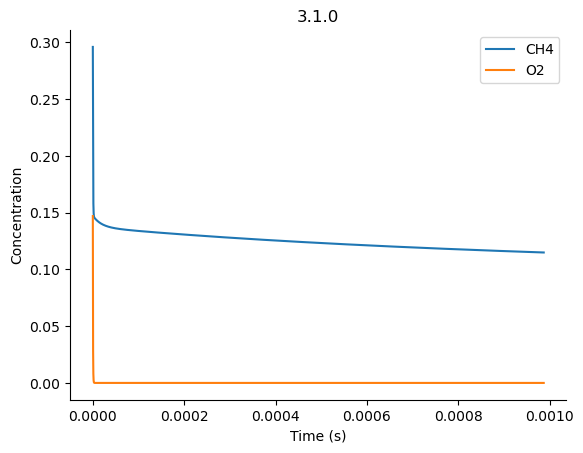

In [26]:
plt.plot(times, [x[i_CH4] for x in gas_concs], label='CH4')
plt.plot(times, [x[i_O2] for x in gas_concs], label='O2')
plt.legend()
plt.title(ct.__version__)
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
ax = plt.gca()
ax.spines[ 'top'].set_visible(False)
ax.spines['right'].set_visible(False)

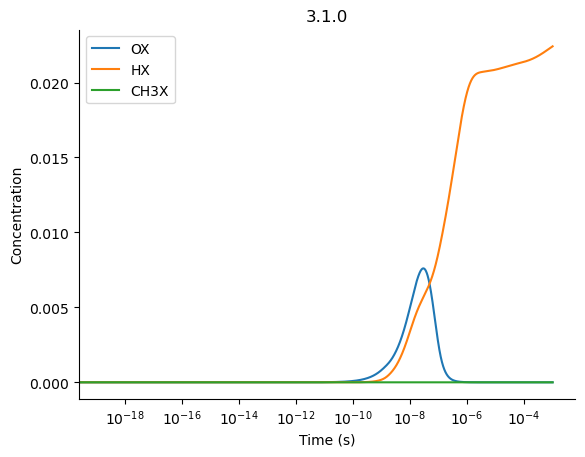

In [30]:
plt.plot(times, [x[i_OX] for x in surf_concs], label='OX')
plt.plot(times, [x[i_HX] for x in surf_concs], label='HX')
plt.plot(times, [x[i_CH3X] for x in surf_concs], label='CH3X')
plt.legend()
plt.title(ct.__version__)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
ax = plt.gca()
ax.spines[ 'top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [20]:
float([x[i_CH4] for x in gas_concs][-1])

0.009482841971419347